# Proyecto Módulo 2: Implementación de un modelo de deep learning

**_Inteligencia artificial avanzada para la ciencia de datos II_**<br>
Alumna: Jackeline Conant Rubalcava <br>
Matrícula: A01280544

Este código fue hecho dentro de la plataforma web llamada Kaggle:<br>
_Para correr este código es necesario que cuentes con el GPU de Kaggle_
https://www.kaggle.com/code/jackelineconant/entrega-reto-individual<br>
Esta es la imágen que agregué de mi mascota para probar el modelo:<br>
https://www.kaggle.com/datasets/jackelineconant/my-dog


## Introducción

**Reto**<br>
Una empresa tecnológica en este caso "The Pokemon Company" desea crear una aplicación móvil innovadora para las personas que les gustan los perros, los fanaticos de videojuegos como Pokemon y veterinarios. La aplicación que desea la empresa debe permitir a los usuarios tomar fotos de perros con sus teléfonos cuando estén ene el exterior y, utilizando el poder de las Redes Neuronales Convolucionales (CNN), identificar la raza del perro en la imagen de forma precisa. Además, esta aplicación debe incluir una funcionalidad estilo "Pokédex" donde, al identificar una raza de perro, esta se registre en un perfil del usuario, que podrá consultar la información detallada de cada raza y compartirla con amigos.<br>

**Introducción al proyecto**<br>
Para este desarrolló un modelo de Red Neuronal Convolucional(CNN) para identificar razas de perros utilizando el dataset de Stanford Dogs, un conjunto de datos que contiene muchas imágenes con labels de diferentes razas de perros. Para mejorar la precisión y la eficiencia del modelo, se implementó una técnica de transfer learning con EfficientNetB0, un modelo preentrenado que ha demostrado un alto rendimiento en tareas de clasificación de imágenes.

La transferencia de aprendizaje con EfficientNetB0 permitió aprovechar el conocimiento adquirido por el modelo en grandes conjuntos de datos, como ImageNet, y ajustarlo a la tarea específica de identificación de razas de perros.

El modelo se entrenó utilizando técnicas de data augmentation para aumentar la variabilidad de las imágenes de entrada y mejorar la capacidad de aprendizaje y generalización que tiene el modelo. 

El objetivo final es crear un clasificador que sea preciso  y que pueda identificar de forma correcta la raza de un perro a partir de una imagen proporcionada(en este caso agregué una foto de mi perro), con la intención de poder completar el reto escrito previamente.

A lo largo de este jupyter Notebook se van a realizar los siguientes pasos:

1. **Exploración, explicación y limpieza de datos**
   * Explicación del dataset
   * Análisis del dataset
   * Proceso de limpieza y transformación de los datos
2. **Desarrollo de un modelo de Deep Learning**
   * Implementación de un modelo Deeplearning
3. **Pruebas con diferentes configuraciones**
4. **Interpretación de resultados**
5. **Conclusión**

## Exploración, explicación y limpieza de datos

Primero importamos las librerías que vamos a estar utilizando durante este código.

In [19]:
# Importar librería para el análisis el Dataset
import numpy as np
import matplotlib.pyplot as plt
# Importar librería para cargar el Dataset e implementar un modelo de CNN
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras import layers, models
# Importar un modelo preentrenado DataTransfer
from tensorflow.keras.applications import EfficientNetB0
# Importar función sklearn para mostrar la precisón y métricas del modelo CNN 
from sklearn.metrics import classification_report
#Importar función para poder procesar una imágen de ejemplo
from tensorflow.keras.preprocessing import image

### Explicación del Dataset

El Dataset tiene el nombre de "Standford_dogs" y proviene de la librería de dataset que contiene Tensorflow(tensorflow_datasets). El Dataset contiene imágenes de 120 razas de perros y el propósito que tiene su diseño es para que pueda ser utilizado en modelos de Deep Learning de clasificación de imágenes.
Esta base de datos cuenta con 20,580 imágenes y 120 clases(las razas de los perros).<br>

_Base de datos: https://www.tensorflow.org/datasets/catalog/stanford_dogs_<br>

La razón por la cual he seleccionado esta base de datos como había mencionado previamente es para su utilización en aplicaciones móviles donde sea neceario identificar a los perros de forma automática. Esto como una forma de que el usuario interactue con el ambiente, utilice la app como entretenimiento y aprenda sobre las razas de perros existentes.

In [3]:
# Cargar el dataset de Standford Dogs

# Definir una variable con el nombre del Dataset en el formato string
nombre_dataset = "stanford_dogs"

# Cargar el Dataset con tensorflows_datasets:
# Se dividen los datos entre set de enrenamiento 'train' y set de prueba 'test'
# Se cargan los datos como pares (imagenes, etiquetas/labels)
(data_train, data_test), ds_info = tfds.load(
    nombre_dataset, 
    split=["train", "test"],
    as_supervised=True,  # Obtén (imagen, etiqueta)
    with_info=True)

### Análisis del Dataset, proceso de limpieza y transformación de los datos

Al analizár el dataset, podemos ver que este consta de 20,580 imágenes de tamaño 224 x 224(se les hizo un resize), distribuidas en 12,000 para el set de entrenamiento y 8,580 para el set de evaluación. Se preprocesaron los datos eliminando prefijos que parecían ser innecesarios y se reemplazaron guiones bajos en los nombres de las razas, facilitando su interpretación y la futura interpretación de los que vieran el código.

Para optimizar el flujo del modelo, se configuró el conjunto de entrenamiento con mezcla aleatoria (shuffle), procesamiento por batches de un tamaño de 32 y un prefetch automático. El conjunto de prueba siguió un flujo similar, sin mezcla. Además, se realizó una visualización exploratoria con gráficas de matplotlibmostrando las primeras 9 imágenes con sus etiquetas para verificar la calidad y correspondencia entre imágenes y clases.

Estas transformaciones aseguran un manejo eficiente del dataset y una correcta preparación para entrenar el modelo.

In [4]:
# Preprocesamiento básico para las imágenes del Dataset de Standford Dogs

# Definimos una variable con el valor 224(tamaño en el que vamos redimensionar nuestras imágenes)
imagen_size = 224

# Generamos una función de preprocesamiento que toma como argumentos una imagen y su label(etiqueta)
# Se usa la función de image.resize de TensorFlow para cambiar el tamaño de la imagen de (None, None, 3) a (224, 224, 3)
# Se normaliza los datos con la división de 255.0 
def preprocesamiento(image, label):
    image = tf.image.resize(image, (imagen_size, imagen_size)) / 255.0
    return image, label

# Ya que estoy eligiendo un tamaño bastante grande de imágenes, decidí disminuir la RAM, solo seleccionandolos con data_train y data_test
# Primeramente preprocesa las imágenes con el tamaño dado y luego las agrupa en batchs de 32
# Finalmente utiliza la funci+on prefetch para poder caragar los datos de mejor manera cuando se vayan a evaluar
data_train = data_train.map(preprocesamiento).shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
data_test = data_test.map(preprocesamiento).batch(32).prefetch(tf.data.AUTOTUNE)

La base de datos contiene los nombres de las razas en strings que se verían de esta manera: "n0225436-husky_siberiano", Entonces fue necesario quitarle a los nombres de las labels los valores previos al primer "-" y remplazar "_" con un espacio. Hay que recordar que van a sobrar algunos "-", pero esos son intencionales.

In [5]:
# Selecciono los nombres de las razas del Dataset Standford_Dogs, organizandolas en listas
nombres_raza = ds_info.features["label"].names

# Quitamos todos los valores del string, previos a el primer guión.
nombres_raza = [s.split('-', 1)[-1] for s in nombres_raza]

# Remplazamos los valores de "_" por un espacio para que los nombres se vean más presentables
nombres_raza = [s.replace('_',' ') for s in nombres_raza]

#Visualizamos la lista de razas(Hay que recordar que hay 120)
print(nombres_raza)

['chihuahua', 'japanese spaniel', 'maltese dog', 'pekinese', 'shih-tzu', 'blenheim spaniel', 'papillon', 'toy terrier', 'rhodesian ridgeback', 'afghan hound', 'basset', 'beagle', 'bloodhound', 'bluetick', 'black-and-tan coonhound', 'walker hound', 'english foxhound', 'redbone', 'borzoi', 'irish wolfhound', 'italian greyhound', 'whippet', 'ibizan hound', 'norwegian elkhound', 'otterhound', 'saluki', 'scottish deerhound', 'weimaraner', 'staffordshire bullterrier', 'american staffordshire terrier', 'bedlington terrier', 'border terrier', 'kerry blue terrier', 'irish terrier', 'norfolk terrier', 'norwich terrier', 'yorkshire terrier', 'wire-haired fox terrier', 'lakeland terrier', 'sealyham terrier', 'airedale', 'cairn', 'australian terrier', 'dandie dinmont', 'boston bull', 'miniature schnauzer', 'giant schnauzer', 'standard schnauzer', 'scotch terrier', 'tibetan terrier', 'silky terrier', 'soft-coated wheaten terrier', 'west highland white terrier', 'lhasa', 'flat-coated retriever', 'cur

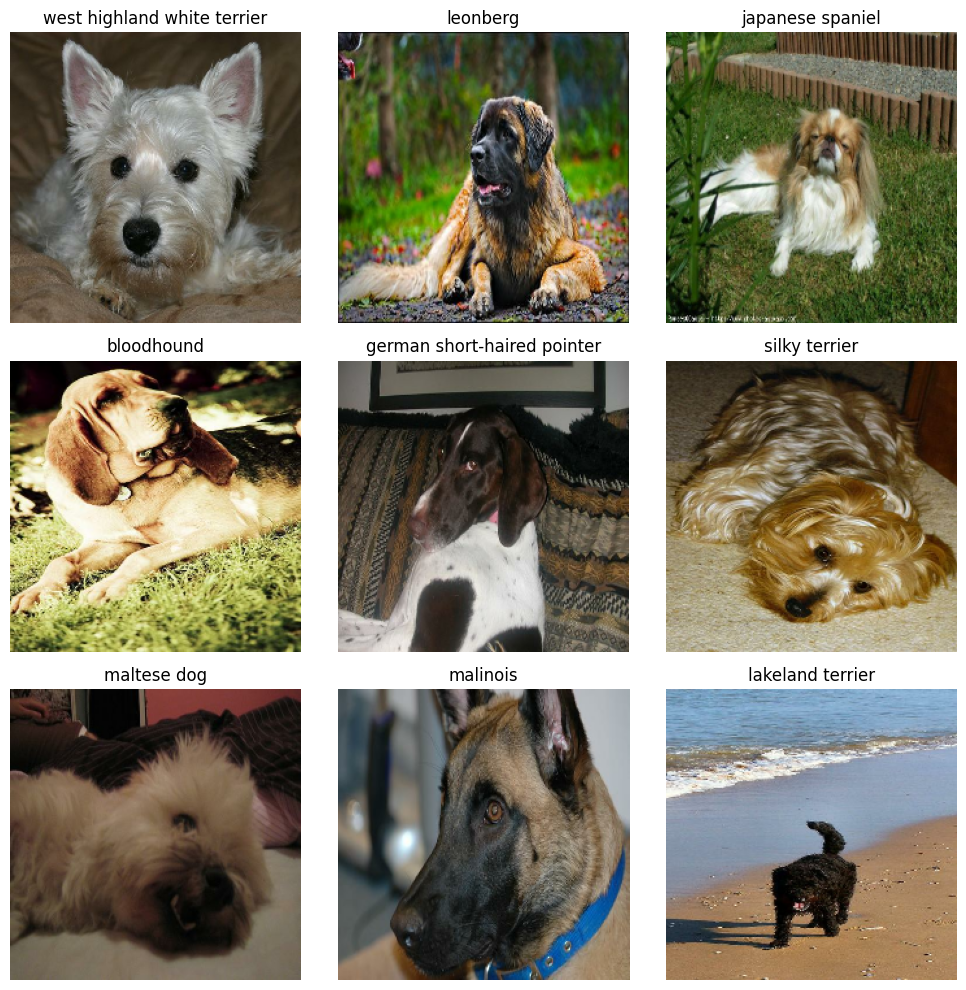

In [6]:
# Obtiene el primer batch(32) de imágenes y labels de los datos de entrenamiento
image_batch, label_batch = next(iter(data_train))

# Creamos una figura con el tamaño de (10,10)
plt.figure(figsize=(10, 10))

# Iteramos con un for las primeras 9 imágenes del primer batch(32) de entrenamiento.
for i in range(9):
    plt.subplot(3, 3, i + 1)  # Tiene 3 filas y 3 columnas
    plt.imshow(image_batch[i])  #Muestra una imagen del batch
    plt.title(f"{nombres_raza[label_batch[i].numpy()]}")  # Muestra el nombre de la raza de la imágen seleccionada
    plt.axis('off')  #Quítamos los ejes

# Ajustamos las gráficas
plt.tight_layout()

#Mostramos la figura con las imágenes de los perros y sus razas
plt.show()


## Desarrollo de un modelo de Deep Learning 

### Implementación de un modelo Deeplearning



Hubo varias complicaciones para el Dataset de Standford_Dogs, primeramente eran varias clases(120), lo que serían casi 174 imágenes por cada raza de perro. Esto hacía más lento el proceso de entrenamiento y lo hacía de forma pésima. Es por esto que me ví en la neecesidad de utilizar Data augmentation, para poder incrementar las imágenes de cada clase, esto terminaba con la RAM que tenía dentro de Kaggle, por lo que fue necesario disminuir el preprocesamiento de datos de x_train y y_train a data_train. Posteriormente el entrenamiento necesito hacer uso de Transfer Learning, para poder mejorar el entrenamiento desde un modelo base que nos serviría para sacar las características y mejorar la precisión del modelo.

**Data Transfering**

El modelo base que se estará utilizando es EfficientNetB0, un modelo preentrenado en el dataset ImageNet. Lo utilizare para extraer las características para mi problema de reconocer las razas de perros. 

* Se carga EfficientNetB0 con los pesos preentrenados en ImageNet, excluyendo la capa final de clasificación, esto me permite reutilizar las capas convolucionales para extraer características generales de las imágenes.

**Data Augmentation**
Se hizo un aumento de datos para incrementar la diversidad y cantidad del conjunto de entrenamiento, mejorando la capacidad del modelo para generalizar a datos no vistos y reduciendo su sobreajuste(overfitting):

* Volteado horizontal
* Rotación aleatoria
* Zoom aleatorio

**Ajusto Fino**
Después de la creación del modelo y su entrenamiento inical, lo que mejoró el modelo de gran manera fue el ajuste fino donde agregue 30 epoch y su precisión final fue de 70%.

In [7]:
# Cargar como modelo base EfficientNetB0 preentrenado:
# Donde se excluye la capa Final que esta conectada al modelo original, 
#     lo que nos permite utilizarlo para sacar las características de nuestro Dataset
# De la misma manera utilizamos los pesos preentrenados en el dataset ImageNet(Cuidado es bastante grande)
base_modelo = EfficientNetB0(
    include_top=False,  # Excluir la capa densa final
    input_shape=(imagen_size, imagen_size, 3),
    weights="imagenet"
)

In [8]:
# Congelar capas preentrenadas para entrenamiento inicial
base_modelo.trainable = False

# Construir el modelo 
modelo = models.Sequential([
    base_modelo,
    layers.GlobalAveragePooling2D(),  # Reducción de dimensiones
    layers.Dropout(0.3),              # Regularización
    layers.Dense(ds_info.features["label"].num_classes, activation="softmax")  # Salida
])

In [9]:
# Compilar el modelo
modelo.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Entrenar el modelo
history = modelo.fit(
    data_train,
    validation_data=data_test,
    epochs=10
)

Epoch 1/10


I0000 00:00:1731730791.855415    3699 service.cc:145] XLA service 0x7f650c003020 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731730791.855492    3699 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  5/375 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.0049 - loss: 4.7926     

I0000 00:00:1731730811.817453    3699 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


375/375 ━━━━━━━━━━━━━━━━━━━━ 60s 75ms/step - accuracy: 0.0084 - loss: 4.8100 - val_accuracy: 0.0061 - val_loss: 4.7981
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.0073 - loss: 4.8072 - val_accuracy: 0.0062 - val_loss: 4.7970
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.0054 - loss: 4.8097 - val_accuracy: 0.0062 - val_loss: 4.8012
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.0068 - loss: 4.8084 - val_accuracy: 0.0100 - val_loss: 4.7940
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.0062 - loss: 4.8116 - val_accuracy: 0.0062 - val_loss: 4.8016
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.0084 - loss: 4.8114 - val_accuracy: 0.0082 - val_loss: 4.7951
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.0068 - loss: 4.8096 - val_accuracy: 0.0062 - val_loss: 4.7932
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - accuracy: 0.0076 - loss: 4.8109 - val_accurac

In [10]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1)
])

# Aplicar la augmentación al modelo
data_train = data_train.map(lambda x, y: (data_augmentation(x), y))

In [11]:
# Descongelar las capas del modelo base
base_modelo.trainable = True

# Recompilar con una tasa de aprendizaje más baja
modelo.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Entrenamiento adicional
fine_tune_epochs = 30
history_fine = modelo.fit(
    data_train,
    validation_data=data_test,
    epochs=fine_tune_epochs 
)

Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 219s 370ms/step - accuracy: 0.0122 - loss: 5.0704 - val_accuracy: 0.0085 - val_loss: 4.7960
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 136s 361ms/step - accuracy: 0.0222 - loss: 4.8060 - val_accuracy: 0.0289 - val_loss: 4.6728
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 133s 353ms/step - accuracy: 0.0353 - loss: 4.6380 - val_accuracy: 0.0788 - val_loss: 4.3822
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 132s 349ms/step - accuracy: 0.0619 - loss: 4.4693 - val_accuracy: 0.1302 - val_loss: 4.1528
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 136s 360ms/step - accuracy: 0.1043 - loss: 4.2794 - val_accuracy: 0.1928 - val_loss: 3.8837
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 134s 355ms/step - accuracy: 0.1410 - loss: 4.0365 - val_accuracy: 0.2593 - val_loss: 3.5772
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 134s 355ms/step - accuracy: 0.1925 - loss: 3.7693 - val_accuracy: 0.3288 - val_loss: 3.2577
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 131s 348ms/step - accuracy: 0.2415 -

## Pruebas con diferentes configuraciones

Para lo siguiente se pudieron analizar que los datos son muy positivos y dan como resultado el 72% de precisión con un recall del 71%, lo que es bastante positivo y significa que los datos van a poder ser utilizados correctamene.

In [16]:
# Evaluar el modelo
loss, accuracy = modelo.evaluate(data_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Generar un reporte de clasificación
from sklearn.metrics import classification_report
import numpy as np

# Predicciones
y_pred = modelo.predict(data_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Verdaderos
y_true = tf.concat([y for _, y in data_test], axis=0)

# Reporte
print(classification_report(y_true, y_pred_classes))

269/269 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.7236 - loss: 0.9715
Test Accuracy: 71.90%
269/269 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step
              precision    recall  f1-score   support

           0       0.67      0.58      0.62        52
           1       0.78      0.89      0.83        85
           2       0.85      0.76      0.81       152
           3       0.78      0.78      0.78        49
           4       0.66      0.61      0.64       114
           5       0.84      0.88      0.86        88
           6       0.89      0.81      0.85        96
           7       0.68      0.68      0.68        72
           8       0.52      0.46      0.49        72
           9       0.85      0.92      0.88       139
          10       0.66      0.81      0.73        75
          11       0.82      0.65      0.73        95
          12       0.78      0.79      0.78        87
          13       0.79      0.65      0.71        71
          14       0.73      0.73      0.73      

Para probar los datos utilicé una imágen de mi mascota.<br>
Se me paso a último momento corregirle el nombre de raza

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


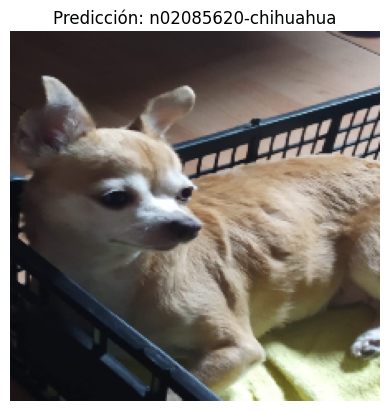

In [ ]:
# Función para cargar y preprocesar una nueva imagen
def cargar_preprocesar_image(img_path):
    img = image.load_img(img_path, target_size=(imagen_size, imagen_size))  # Cargar la imagen y redimensionarla
    img_array = image.img_to_array(img)  # Convertir la imagen a un array numpy
    img_array = np.expand_dims(img_array, axis=0)  # Añadir la dimensión del batch
    img_array = img_array / 255.0  # Normalizar la imagen (mismo preprocesamiento que en el entrenamiento)
    return img_array

# Subir la imagen a Kaggle, típicamente en una carpeta 'working'
img_path = '/kaggle/input/my-dog/WhatsApp Image 2024-11-15 at 7.22.23 PM.jpeg'  # Ruta de la imagen subida

# Cargar y preprocesar la imagen
img = cargar_preprocesar_image(img_path)

# Predecir utilizando el modelo entrenado
prediccion = modelo.predict(img)

# Obtener la clase predicha
predicted_class = np.argmax(prediccion, axis=1)
class_label = ds_info.features['label'].int2str(predicted_class[0])  # Convertir a etiqueta de clase

# Mostrar la imagen y su predicción
plt.imshow(img[0])
plt.title(f"Predicción: {class_label}")
plt.axis('off')  # Ocultar los ejes
plt.show()


## Interpretación de resultados

El código muestra cómo se evaluó un modelo de transfer learning y cómo varios factores afectaron su rendimiento. Usando un modelo preentrenado (EfficientNetB0), se mejoró la clasificación de un nuevo conjunto de datos, evitando tener que entrenar desde cero. El optimizador Adam fue más rápido en comparación con SGD, y con una tasa de aprendizaje adecuada, permitió un ajuste eficiente de los parámetros.

Seleccioné los primero 10 para poder verlos con más detalle:

          precision    recall  f1-score   support

           0       0.67      0.58      0.62        52
           1       0.78      0.89      0.83        85
           2       0.85      0.76      0.81       152
           3       0.78      0.78      0.78        49
           4       0.66      0.61      0.64       114
           5       0.84      0.88      0.86        88
           6       0.89      0.81      0.85        96
           7       0.68      0.68      0.68        72
           8       0.52      0.46      0.49        72
           9       0.85      0.92      0.88       139

     accuracy                          0.72      8580
    macro avg      0.72      0.71      0.70      8580


Lastimosamente no pude tener los 2 modelos corriendo ya que pesaban mucho para el Kaggle y además cada uno tardaba una hora y media en cargar, pero guarde los resultados de cuando se utilizaba fine_tuning de 20 epochs:

     precision    recall  f1-score   support

           0       0.49      0.50      0.50        52
           1       0.69      0.87      0.77        85
           2       0.79      0.83      0.81       152
           3       0.65      0.65      0.65        49
           4       0.59      0.57      0.58       114
           5       0.87      0.85      0.86        88
           6       0.88      0.85      0.87        96
           7       0.60      0.72      0.66        72
           8       0.38      0.35      0.36        72
           9       0.75      0.84      0.80       139

     accuracy                          0.67      8580
     macro avg     0.66      0.66      0.65      8580


Al ajustar el modelo con solo 10 épocas(fue de 55 de accuracy), la precisión fue baja, pero al aumentarlas a 30, la precisión subió al 70%. Esto demuestra que un entrenamiento más largo permite que el modelo refine mejor sus predicciones. En resumen, transfer learning, el optimizador Adam y un mayor número de épocas ayudaron a mejorar el rendimiento del modelo.

##  Conclusiones

En conclusión, el uso de transfer learning con un modelo preentrenado como EfficientNetB0 fue clave para mejorar la clasificación de imágenes sin necesidad de entrenar desde cero, lo que aceleró considerablemente el proceso. El optimizador Adam demostró ser más rápido que SGD(como por unos 3-4 segundos por epoch), permitiendo un entrenamiento más eficiente y un ajuste adecuado de los parámetros. A través del ajuste fino y un aumento en el número de épocas, se logró mejorar la precisión del modelo, alcanzando un 70% después de 30 épocas, lo que resalta la importancia de un entrenamiento más prolongado para refinar las predicciones.

El reto estuvo en encontrar el equilibrio entre la rapidez del optimizador y la cantidad de épocas necesarias para optimizar el modelo, demostrando cómo ajustes en estos parámetros pueden marcar una gran diferencia en los resultados finales. Este enfoque no solo mostró la efectividad de transfer learning para tareas de clasificación de imágenes, sino también cómo pequeñas variaciones en el proceso de entrenamiento pueden mejorar significativamente el rendimiento.